In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    balanced_accuracy_score,
    f1_score,
)
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD

import util

%matplotlib inline

pd.set_option('max_colwidth', None)

# Classifying Rakuten Product Categories

__Goal__: Determine whether it is viable to automatically classify product descriptions into their Rakuten categories, with some human assistance. 

__Summary__: At a high-level, it will likely be possible (with further work) to automatically classify the majority of product descriptions. There are a few important caveats. Some categories, namely common catagories that are well-represented in the data, are more amenable to prediction than other categories. For example, category `1208` is made as an incorrect prediction over 90% of the  time, and so any predicted label of `1208` would need to be hand-verified. Luckily, poor prediction is clustered around a set predicted labels -- only about 25% of all predictions are for a category with predictive accuracy under 50%, and over half of predictions are for categories with over 90% predictive accuracy. In addition, the prediction quality may deteriorate the deeper into categorization we go (that is, the first level of categorization will likely be more accurate than the next level). Deeper levels are less well-represented in the data.

This notebook will walk through the EDA, feature development, model building, and model evaluation for one thread of analysis. In the interest of keeping this analysis tight, I've moved less-important analysis to the bottom of this notebook (appendix).

In [2]:
rktn_train_url = (
    "https://github.com/up-lab/rakuten-data-challenge/raw/master/rdc-catalog-train.tsv"
)
rktn_test_url = (
    "https://github.com/up-lab/rakuten-data-challenge/raw/master/rdc-catalog-test.tsv"
)

rktn_train_df = pd.read_csv(rktn_train_url, delimiter="\t", header=None)
rktn_test_df = pd.read_csv(rktn_test_url, delimiter="\t")

# The original training data does not have column names; I've pulled them from the test set
rktn_train_df.columns = rktn_test_df.columns[:]

In [3]:
# common test and train sets
train_X, train_y = util.load_standard_x_y(rktn_train_df)
test_X, test_y = util.load_standard_x_y(rktn_test_df)

## EDA 

For the sake of time, I'm going to restrict myself only to the first category level, noting that given more time, I could also consider additional category levels. I decided to do this in order to reduce the amount of error.

In order to understand the data, I want to understand:
1. How balanced is the target? This will help me understand what evaluation metric to give most weight to. For example, given a well-balanced target, I could use accuracy as an effective metric. Without balance, I will need to evaluate with more nuance.
2. What does my data look like? This takes many forms, but for the purposes of this exercise, I'm interested in better understanding how distributed top words are among each category, as well as take a look at a few sample titles. This is largely so that I have a better sense of how to move forward with the modeling.

### How balanced is the target?

It seems like the target categories are not particularly well-balanced. In fact, the top 4 categories represent about half of all products. There are some categories that represent under 1% of all products (like 1208). I'll keep this in mind for additional analysis. 

In [4]:
category_1_count = rktn_train_df["category_level_0"].value_counts(ascending=False)
category_1_count.reset_index().rename(
    columns={"index": "category_level_0", "category_level_0": "count"}
)

,category_level_0,count
0,4015,268295
1,3292,200945
2,2199,96714
3,1608,85554
4,3625,29557
5,2296,28412
6,4238,23529
7,2075,20086
8,1395,18847
9,92,8172


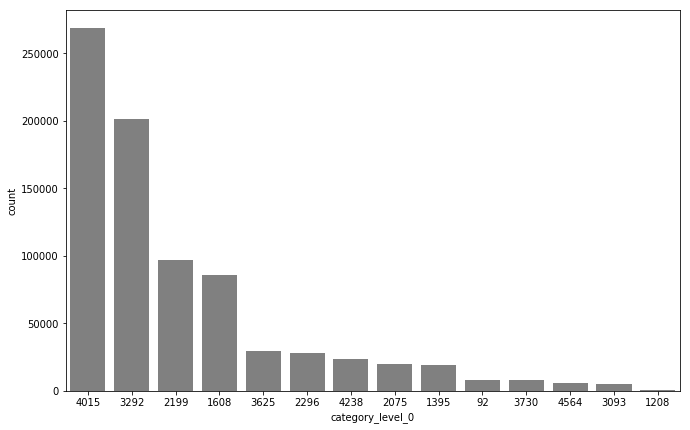

In [5]:
plt.figure(figsize=(11, 7))
sns.countplot(
    rktn_train_df["category_level_0"], order=category_1_count.index, color="gray"
)
plt.show()

### What does the data look like?

The purpose of this question is to get a better feel of the data. I address this question in a few steps. 
1. Looking at a few sample products
2. Looking at a few common words 

Because this data necessarily involves constructing features from text, and I would like to start with as simple features as possible, for the first attempt at the assignment, I'd like to look at a few sample product titles to get a good sense of how I should approach creating features. For example, if the product descriptions were long and involved, perhaps I'd want to preserve directional relationships between words. 

In [6]:
np.random.seed(2020)
rktn_train_df.sample(10)[["Title", "CategoryIdPath"]]

,Title,CategoryIdPath
520684,Canon EOS 6D 20.1 MP Digital SLR Camera (Body) plus 32GB Accessory Kit,3292>1041>4175>1077>1242
594994,"ACCUFORM SIGNS MEQM340VS Warning Sign, 10 x 14In, BK/ORN, ENG, Text",4015>2028>3840
603078,4.9mm Drilling Dia HSS Cobalt Metric Spiral Twist Drill Bit Rotary Tool 6pcs,4015>3754>3663>512>4157>2564
750199,Mitsubishi VLT-HC3LP Projector Housing with Genuine Original OEM Bulb,3292>290>497
798258,Buy Enlarge 0-587-26574-4C12X18 Kakitsubata - Iris Laevigata in a Tsubo- Canvas Size C12X18,4015>4245>2682
635826,"Victor Muffler Saddle Camp 1-7/8"" 13 Ga. Steel",4015>2028>2159
651082,ReadyLift 69-8000 SST Lift Kit Fits 06-10 Ridgeline,2199>4592>12
433456,"KIPP 06460-1A21X30 Adj Handle, MD, 1/4-20, Ext, 1.18, 1.85",4015>3754>3580>31
384733,Lo Mas Lejos A Tu Lado,2296>3597>2002
686252,Max Roach Live In Berlin,2296>3597>2093


The descriptions here are quite sparse. Indeed, they contain some product-specific lingo and a lot of things that I don't immediately understand. For example, I don't really understand the entire entry, `KIPP 06460-1A21X30 Adj Handle, MD, 1/4-20, Ext, 1.18, 1.85`. On the other hand, it seems like this text is sufficiently simple to use bag-of-words or TF/IDF for feature generation.  

To get a better sense of how this will look, I'll first take a BOW with a few additions: I'll stem the words (I want `Live` and `Living` to be the same for now), I'll remove the number-only "words", and I'll restrict myself to the top 20 or so words by count. Note that the stemming doesn't come default with `sklearn`'s text feature extraction tools; it requires `nltk`.  

In [7]:
eda_vectorizer = util.CountVectorizerWithStemming(
    max_features=20, token_pattern=u"(?ui)\\b\\w*[a-z]+\\w*\\b"
)

In [8]:
eda_vectorizer_output = eda_vectorizer.fit_transform(rktn_train_df["Title"]).toarray()
eda_vectorizer_output_df = pd.DataFrame(eda_vectorizer_output)
eda_vectorizer_output_df.columns = eda_vectorizer.get_feature_names()
eda_vectorizer_output_df = eda_vectorizer_output_df.assign(
    original_text=rktn_train_df["Title"], category=rktn_train_df["category_level_0"]
)

In [9]:
top_word_means = eda_vectorizer_output_df.groupby("category").mean()
top_word_means.idxmax()

and           3292
batteri       3292
black         3093
cover         3292
decal         3292
filter        4015
for           3292
in            3093
mightyskin    3292
pack          1208
protect       3292
replac        4015
s             1608
silver        1608
skin            92
vinyl         3292
white         1608
with          2075
wrap          3292
x             4238
dtype: int64

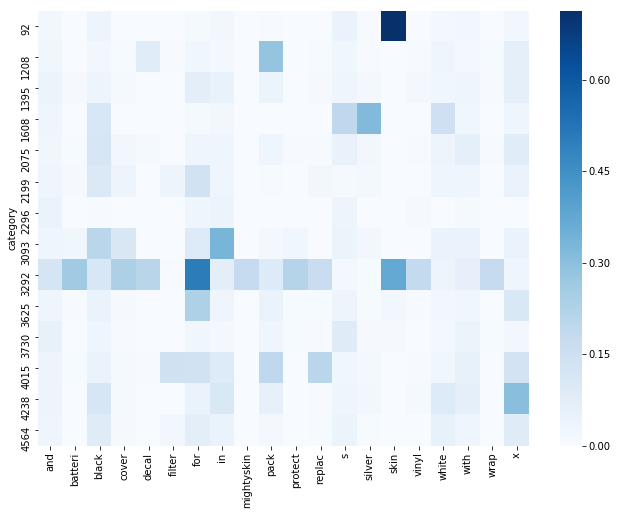

In [10]:
plt.figure(figsize=(11, 8))
sns.heatmap(top_word_means, cmap="Blues")
plt.show()

## Training model

At this point, the EDA suggests to me that BOW and TF-IDF are likely good feature creation strategies -- I don't need something more complex, at least initially. I'm also interested in using the simplest and most explainable classifier possible; I'm going to use`MultinomialNB`, a go-to standard for texty stuff. In the appendix, I'll also describe how I would use a `Gradient Boosting Classifier`, which is my favorite all-purpose classifier. 

### Potential baselines

Before I do, though - I want to get a sense of what my performance metrics would look like if I simply randomly assigned all labels in the proportions they occur in the data to the dataset as a potential baseline. I already know that if I assigned all products to category `4015`, I'd be right about 33.5% of the time, so I'm looking for a second datapoint. I also want to look at `balanced accuracy` because I know my sample is imbalanced (average recall by class). Note that the `sklearn` implementation is equivalent to the class-weighted accuracy score.  

In [11]:
y_all_4015 = np.full(fill_value=4015, shape=rktn_train_df.shape[0])
display(balanced_accuracy_score(train_y, y_all_4015))
accuracy_score(train_y, y_all_4015)

0.07142857142857142

0.33536875

In [12]:
y_permutation = rktn_train_df["category_level_0"].sample(rktn_train_df.shape[0])
display(balanced_accuracy_score(train_y, y_permutation))
accuracy_score(train_y, y_permutation)

0.07170623068666958

0.206985

### Building a model

I'm not super concerned about which type of model is best yet -- feature development and modeling are not yet refined enough for small differences between models to make a big difference. But, I'm going to try a `MultinomialNB` with `BOW` and `TF/IDF`.
    
*Note that stemming takes a while to do (I don't write code as clean as `sklearn` developers), so absent significant benefits, I won't explicitly use it in this round of analysis.

### A note on feature generation

The vocubulary for this is very large and quite sparse (see above). Because it's relatively sparse, I wanted to investigate an analytical way to reduce the dimensionality of the data (and evaluated that first). For ease of use, I chose to first evaluate using TruncatedSVD; this analysis is in the appendix. I also compared this to a less-nuanced dimensionality reduction strategy -- taking the top 1200 words.  

A few notes here:
  1. I'd like to reduce the number of features as much as possible so that I don't *overfit* my model. My dictionary, given infinite features, is over 400,000 words long, and there are 800,000 training records, so 12,000 features seems reasonable to me as a rough yardstick assumption. One way to refine this for the future would be to use a more nuanced dimensionality reduction strategy, like SVD or PCA; these are time intensive, and so I haven't included them in this round of analysis, but they are promising -- see how much variance is explained by just 100 components! This is in the appendix.
  2. GradientBoostingClassifiers, etc. take a long time, so how I would approach using them is also in the appendix.

In [13]:
cv = CountVectorizer()
dictionary = cv.fit(train_X)
len(dictionary.vocabulary_)

427297

#### Multinomial NB

In [14]:
bow_mnb_pipeline = util.create_pipeline("bow", MultinomialNB())
bow_mnb_clf = util.fit_predict_score_pipeline(bow_mnb_pipeline, train_X, train_y)

Accuracy: 0.78458875
Balanced Accuracy: 0.8102575471829073
Precision: 0.85884180091796
F1: 0.8047679722365743


In [15]:
tfidf_mnb_pipeline = util.create_pipeline("tfidf", MultinomialNB())
tfidf_mnb_clf = util.fit_predict_score_pipeline(tfidf_mnb_pipeline, train_X, train_y)

Accuracy: 0.7913875
Balanced Accuracy: 0.8141386853520619
Precision: 0.8623325579163597
F1: 0.8104631793593747


In [16]:
bow_stem_mnb_pipeline = util.create_pipeline("bow_stem", MultinomialNB())
bow_stem_mnb_clf = util.fit_predict_score_pipeline(
    bow_stem_mnb_pipeline, train_X, train_y
)

Accuracy: 0.77981
Balanced Accuracy: 0.809062636246037
Precision: 0.8556556181537625
F1: 0.8001312164855549


##### Quick checks

As you might expect, these similar methods have relatively similar performance. TF/IDF is slightly better (even though BOW is strictly more allowable for Multinomial Naive Bayes)... but I want to check a few things. 

1. The final parameters used (is the model sufficiently regularized?)
2. The balance of predictions

Both of these seem reasonable to me.

I'm also interested to see if there are any patterns of miscategorization. For example, is a label of category `4015` more or less valid than another label? This matters: if prediction errors are scattered across categories, it would be a lot harder to quickly check than if prediction errors tend to be more concentrated. For this application, it seems like only a few groups are reliably predicted well -- the most common categories. This would be worth thinking through more to see if there's another way to hone in on whether something is one of the smaller categories. 

In [17]:
tfidf_mnb_clf.named_steps["classifier"].best_params_

{'alpha': 0.25, 'fit_prior': False}

In [18]:
util.show_balance_table(
    rktn_train_df,
    "tfidf_mnb_prediction",
    clf=True,
    classifier_pipe=tfidf_mnb_clf,
    train_X=train_X,
)

tfidf_mnb_prediction     False     True 
category_level_0                        
4015                  0.328944  0.671056
2296                  0.304202  0.695798
2075                  0.253958  0.746042
1395                  0.250862  0.749138
3625                  0.236458  0.763542
3730                  0.189449  0.810551
1208                  0.159223  0.840777
4238                  0.151940  0.848060
4564                  0.148194  0.851806
92                    0.145497  0.854503
3292                  0.130877  0.869123
2199                  0.123984  0.876016
3093                  0.095528  0.904472
1608                  0.082942  0.917058


#### What share of predicted values were correct?

In [19]:
rktn_train_df.groupby("prediction")["tfidf_mnb_prediction"].mean().sort_values()

prediction
1208    0.076583
4564    0.306141
3093    0.322470
2075    0.392555
1395    0.432554
3730    0.438342
92      0.447456
4238    0.459886
2296    0.689680
3625    0.754278
2199    0.828757
1608    0.939561
4015    0.951973
3292    0.967970
Name: tfidf_mnb_prediction, dtype: float64

## Testing

At this point, I feel reasonably comfortable with the MNB classifier that uses TF/IDF for preprocessing, so I'm going to test it! When I test it, I'm looking for:
1. Metrics as good as on the training data (but not better)
2. Similar balance to the training data
3. A clear pattern of categorization errors

I see that the metrics are slightly worse but the balance looks somewhat comparable. Similarly, it looks like there are some categories that are reliably predicted (and some that are not). 

The final two tables here, for me, are very promising -- they suggest that it will be possible to hand verify specific predicted categories (rather than every entry), and that most predictions by count do not need to be checked (almost 70% of predictions fall into the four best predicted categories). 

In [20]:
pred_y = tfidf_mnb_clf.predict(test_X)
util.evaluate_model(test_y, pred_y)

Accuracy: 0.772885
Balanced Accuracy: 0.793481762892851
Precision: 0.8492580103975316
F1: 0.7946854742811983


In [21]:
util.show_balance_table(
    rktn_test_df, colname="tfidf_mnb_prediction", clf=False, y_data=pred_y
)

tfidf_mnb_prediction     False     True 
category_level_0                        
2296                  0.474997  0.525003
3625                  0.333333  0.666667
4015                  0.330910  0.669090
2075                  0.271168  0.728832
1395                  0.238901  0.761099
3730                  0.223769  0.776231
2199                  0.169473  0.830527
92                    0.149952  0.850048
4238                  0.133099  0.866901
3292                  0.128070  0.871930
3093                  0.124289  0.875711
1208                  0.115702  0.884298
1608                  0.106215  0.893785
4564                  0.091375  0.908625


#### What share of each predicted label was correct? 

In [22]:
rktn_test_df.groupby("prediction")["tfidf_mnb_prediction"].mean().sort_values()

prediction
1208    0.036161
4564    0.269367
3093    0.296235
2075    0.345423
1395    0.383607
3730    0.408639
4238    0.453699
92      0.456527
2296    0.610412
3625    0.704561
2199    0.837512
1608    0.905286
4015    0.941323
3292    0.964708
Name: tfidf_mnb_prediction, dtype: float64

#### How common is each label?

In [23]:
rktn_test_df["prediction"].value_counts(normalize=True)

4015    0.235185
3292    0.226115
2199    0.126625
1608    0.104525
4238    0.054265
2075    0.049215
1395    0.040445
3625    0.036945
2296    0.035345
4564    0.019750
92      0.019495
3730    0.019100
3093    0.018195
1208    0.014795
Name: prediction, dtype: float64

### Appendix: Extra analyses that didn't make the narrative cut

#### Why only the first category?
There were two key reasons for this:
1. The second category depended on the first. That is, a product with a first category of `3292` could have multiple second level categories, but all products with a second category level of `49` belonged to a higher category group of `3219`.
2. These groupings are sparse! For example, there are only 21 examples of `4564>248`. In a dataset of 800,000, that is a sufficiently rare event that it would take significantly more than a few hours to tackle.

In [24]:
rktn_test_df.groupby(["category_level_1", "category_level_0"])[
    "category_level_1"
].count()

category_level_1  category_level_0
49.0              3292                3219
114.0             3292                8256
248.0             4564                  21
282.0             4015                3227
290.0             3292                1618
                                      ... 
4868.0            4015                  35
4889.0            3093                 240
4914.0            4564                 364
4931.0            3625                  51
4960.0            4238                 191
Name: category_level_1, Length: 107, dtype: int64

#### Feature selection 

In order to get a better sense of how I could reduce dimensionality here, I've included some of the analysis I used below.

In [25]:
cv_reduced = CountVectorizer(max_features=20000)
dictionary_reduced = cv_reduced.fit_transform(train_X)

In [26]:
reduced_dictionary_array = dictionary_reduced.toarray().sum(axis=0)

sparse_words = 0
for count in reduced_dictionary_array:
    if count < 800:  # appears in fewer than 0.1% of records
        sparse_words += 1

sparse_words

18481

In [27]:
svd = TruncatedSVD(n_components=100)
svd.fit(X=dictionary_reduced)
print(svd.explained_variance_ratio_.sum())

0.3709092400392085


#### What are some standard "new dataset" practices that are boring to read about?

In order to get my legs with any new dataset, I usually would verify the beginning, end, and a few sample rows of the dataset for integrity, try to get a good sense of the size and shape of the data, and learn the data types. This preliminary inspection, even though it's quite basic, is important to me! For example, it's how I realized to allow a variable number of categories for the classification exercise, or how I learned that I could potentially ignore numbers or atypical strings from the modelling. I've included a quick sample of this sort of very basic analysis not because I think it's particulary advanced or unique, but because I think it has often outsize importance. 

__As a note__: This shows the analysis with the test set, because the test set is smaller to re-read in. In practice, I would only look at the column names of the test set, the shape, and the dtypes before training any model. 

In [29]:
rktn_test_df = pd.read_csv(rktn_test_url, delimiter="\t")

In [30]:
rktn_test_df.dtypes

Title             object
CategoryIdPath    object
dtype: object

In [31]:
rktn_test_df.shape

(200000, 2)

In [32]:
rktn_test_df.head()

,Title,CategoryIdPath
0,"Sterling Silver Dangle Ball Earrings w/ Brilliant Cut CZ Stones & Yellow Topaz-colored Crystal Balls, 1"" (26 mm) tall",1608>2320>2173>3813
1,ALTERNATOR FREIGHTLINER FL FLC 112 120 FLD 112 120 M2 BY 110-555PRM 110-555P 110-910 110-555PRM,2199>4592>12
2,Disc Brake Rotor-Advanced Technology Rear Raybestos 980368,2199>4592>12
3,Coquette Neon Pink Ruffle Babydoll 7035 Neon Pink One Size Fits All,1608>4269>3031>1221
4,12V 7Ah (SPS Brand) APC NS3000RMT3U Replacement Battery ( 4 Pack),3292>114>1231


In [33]:
rktn_test_df.tail()

,Title,CategoryIdPath
199995,14K White Gold Synthetic Ruby Ring Sz 10,1608>2320>3648
199996,Blue Stone Box Large,4015>3636>526>3651
199997,8-Pack Replacement Engine Air Filter for 2003 Ford Mustang V8 4.6 Car/Automotive,4015>2337>1458>40
199998,"WALTER F4253.B32.100.Z05.12 Indexable Mill Cutter, F4253B32100Z0512",4015>3754>3663>512>634
199999,"Skin for Microsoft Surface Pro (2017) 12.3"" - Deer Hunter| MightySkins Protective, Durable, and Unique Vinyl Decal wrap cover | Easy To Apply, Remove, and Change Styles | Made in the USA",3292>49>2166


In [34]:
rktn_test_df.sample(10)

,Title,CategoryIdPath
40571,"QUARTET AF32 A-Frame Sign Holder, Freestanding, 24x36",4015>2028>3840
114443,0.70 Ct Oval Orange Red Madeira Citrine Sterling Silver Solitaire Ring,1608>2320>3648
158271,"Ana Silver Co Malachite 925 Sterling Silver Pendant 2"" - Handmade Jewelry PD547144",1608>2320>498>1546
7754,Alpha Omega Publications HIS 0102 Communicating With Sound,4015>3271>4724>539
108163,24 Miele Revolution (Power Plus) 5000 Vacuum Bags with 24 Micro Filters - (2 x 12 Pack),4015>2337>2943>4735>3582>1998
41662,"19-1/2""L Micrometer Micrometer Torque Wrench, Westward, 6PAJ0",4015>3754>3663>1500>1664
96756,Daystar KU20002YL Shock Therapy Full Size Shock Boot,2199>4592>12
69348,Home City 300FQDC SLLV 300 F-Q Duvet Cover Set Egyptian Cotton Solid-Lavender,4015>3636>1319>1409>3606
26398,Disc Brake Pad-Police Rear Bendix PBD999,2199>4592>12
160299,Silver Royal Western Saddle Mini Barrel High Noon Brown Hair SR8768,2075>1724>3017>1958>2737


#### Gradient Boosting Classifier version

__This is aspirational__ because they take a long time to run, but... I'd ideally like to run a `GradientBoostingClassifier` with:
    - `BOW` without stemming
    - `BOW` with stemming*
    - `TF/IDF` without stemming (and depending on the result, with)
    
I'm not quite at the stage where trying another model makes much sense, but this would be another option. GBM would be good for the unbalanced data, and is a generally good all-purpose more traditional classifier. 

In [35]:
param_grid = {"learning_rate": [0.001, 0.01, 0.1], "max_depth": [1, 3, 5]}
gbc_kwargs = {
    "n_estimators": 2000,
    "n_iter_no_change": 10,
    "tol": 0.01,
    "validation_fraction": 0.2,
}

```
bow_gbc_pipeline = util.create_pipeline("bow", GradientBoostingClassifier(**gbc_kwargs), param_grid=param_grid)
bow_gbc_clf = util.fit_predict_score_pipeline(bow_gbc_pipeline, train_X, train_y)
tfidf_gbc_pipeline = util.create_pipeline("tfidf", GradientBoostingClassifier(**gbc_kwargs), param_grid=param_grid)
tfidf_gbc_clf = util.fit_predict_score_pipeline(tfidf_gbc_pipeline, train_X, train_y)
```